In [1]:
import numpy as np
import pandas as pd 
from scipy import stats
import pickle as pkl
import random

import matplotlib as mpl
import matplotlib.pyplot as plt

import pymc as pm
import os
os.environ['AESARA_FLAGS'] = 'base_compiledir=/nfs/research/gerstung/alomakin/.aesara'
import aesara
from aesara import tensor as at
import cloudpickle as cpkl

import sys
sys.path.append('../')
from basiss.models import beta_moments, gamma_moments
from basiss.preprocessing import Sample, mask_infisble, generate_data4model, to_grid
from basiss.models import store_essential_params, sample_essential
from basiss.models.diagnostic_plots import display_raw_fields, diagnostic_residual, gaussian_prior_check
from basiss.models import beta_sum_logp
mpl.rcParams['pdf.fonttype'] = 42

In [2]:
%load_ext autoreload
%autoreload 2

## Sample load 

In [3]:
with open('../submission/generated_data/data_structures/data_case2_saved.pkl', 'rb') as file:
    saved_lists = pkl.load(file)
imm_sample_list = saved_lists['imm_sample_list']
exp_sample_list = saved_lists['exp_sample_list']
mut_sample_list = saved_lists['mut_sample_list']


### Loading IHC masks 

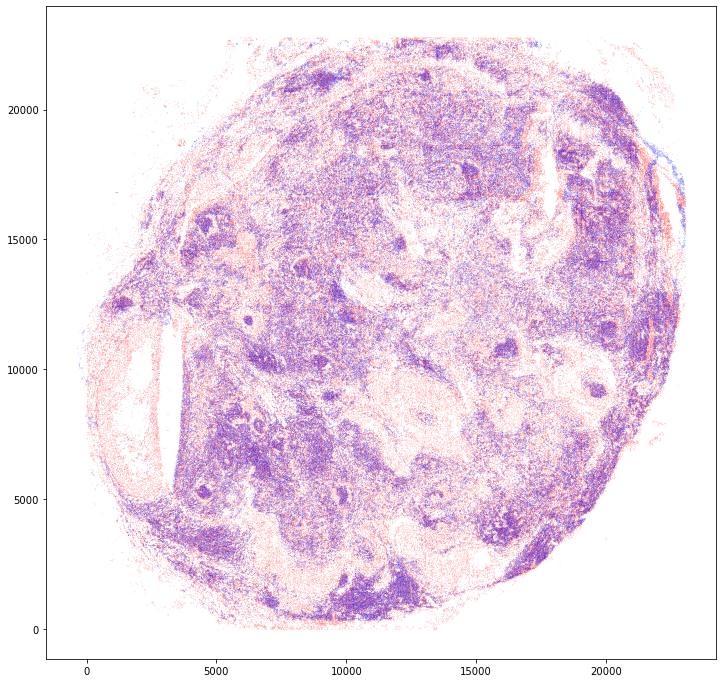

In [4]:
#Additional infomation about cell types 

pd14780e_CD45 = pd.read_csv('../submission/external_data/PD14780/IHC/masks/Imm_PD14780e_CD45_warped.csv')

plt.figure(figsize=(12,12))
plt.scatter(mut_sample_list[2].cellpos[:,0], mut_sample_list[2].cellpos[:,1], s=0.001, color='red')
plt.scatter(pd14780e_CD45.x, pd14780e_CD45.y, s=0.001, color='blue')

plt.gca().set_aspect('equal')

## Construct model data

#### Loading genotype matrix (tree)

The genotype matrix $\mathbf{G}$ contains the number of each allelic copy in each clone $s$. $\mathbf{G}$ is a matrix representation of the underlying phylogenetic tree and provides the instructions of the allelic configuration in each branch of the tree.

In [5]:
#loading tree 
genes_to_drop= []
tree = pd.read_csv('../data/PD14780_tree.csv',index_col=0)

In [6]:
#adding 2 wt classes
M = np.array(tree.iloc[:-1])
M_wt = np.array(tree.iloc[-1])
n_wt=2
M = np.concatenate([M] + n_wt * [M_wt[None,:]],axis=0)

#### Calculating VAF data from WGS  

WGS data contains information of the mutated allele frequencies on the whole slide. We can use this data to better regularise the model

We construct a Beta pseudo-likelihood of $\mathbf{VAF}^{\text{BaSISS}}$ with $\alpha$ and $\beta$ parameters proprtional to the number of mutated and wild-type reads in WGS experiment. We use parameter $u=5$ to inflate uncertainty in WGS data as it comes from proximal but not exactly the same slide we are observing in BaSISS experiment. 

$$\text{VAF}^{\text{BaSISS}}_m \sim \mathrm{Beta}(\alpha=\text{WGS}^\text{mut}_m / u + 1, \alpha=\text{WGS}^\text{wt}_m / u + 1)$$

In [7]:
u=5
wgs_data = pd.read_csv('../submission/external_data/PD14780/WGS/PD14780_genome_data_jan_2020.csv')
wgs_data = wgs_data[np.logical_not(np.isin(wgs_data.Gene,genes_to_drop))]
wgs_names = np.array(wgs_data.Gene)
wgs_wt = []
wgs_mut = []
for i, s in enumerate('ade'):
    wgs_mut.append(np.array(wgs_data[f'dis_MtAll_PD14780{s}']))
    wgs_wt.append(np.array(wgs_data[f'dis_depth_PD14780{s}'] - wgs_data[f'dis_MtAll_PD14780{s}']))

#wgs_wt.append(np.array([M[:,np.where(tree.columns == gene + 'wt')[0][0]].mean(axis=0) for gene in wgs_names]))
#wgs_mut.append(np.array([M[:,np.where(tree.columns == gene + 'mut')[0][0]].mean(axis=0) for gene in wgs_names]))
#wgs_wt.append(wgs_wt[0]/5)
#wgs_mut.append(wgs_mut[0]/5)
#wgs_wt.append(wgs_wt[0]/5)
#wgs_mut.append(wgs_mut[0]/5)

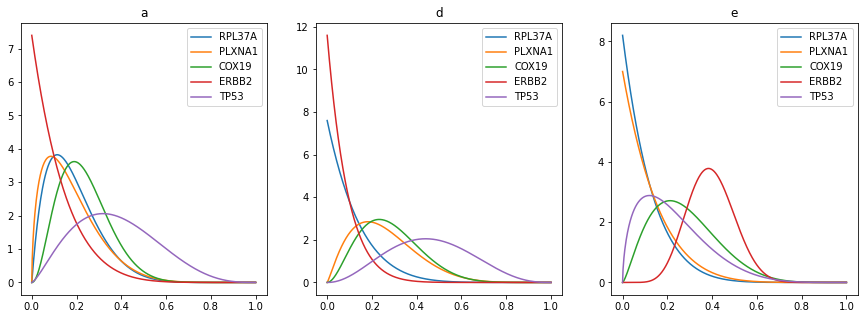

In [8]:
plt.figure(figsize=(15,5))
for s in range(3):
    plt.subplot(1,3,s+1)
    for i in range(len(wgs_names)):
        plt.plot(np.linspace(0.0,1,500), stats.beta(wgs_mut[s][i]/u + 1, wgs_wt[s][i]/u+1).pdf(np.linspace(0.0,1,500)), label=wgs_names[i])
        #plt.ylim(0,100)
        plt.legend()
        plt.rcParams['figure.facecolor'] = 'w'
    plt.title('ade'[s])

#### Loadin BaSISS data

The counts of all probes can be represented by a three dimensional array $\mathbf{D} \in \mathbb{N}^{|a|\times |x| \times |y|}$, where $a$ refers to the allele and $x$ and $y$ are course grained coordinates on a regular grid of dimensions $|x| \times |y|$. The grid size was chosen to be  108.8$\mu$m considering a trade-off between data sparsity, precision and computational cost.

100%|██████████| 21/21 [00:00<00:00, 63.81it/s]
/nfs/research/gerstung/alomakin/projects/bassis/repo/BaSISS/notebooks/../basiss/preprocessing/_model_data_preparation.py:27: RuntimeWarning: divide by zero encountered in true_divide
  mask_infisiable = mut_sample_list[i].gene_grid['infeasible']/t < 0.1
/nfs/research/gerstung/alomakin/projects/bassis/repo/BaSISS/notebooks/../basiss/preprocessing/_model_data_preparation.py:27: RuntimeWarning: invalid value encountered in true_divide
  mask_infisiable = mut_sample_list[i].gene_grid['infeasible']/t < 0.1
100%|██████████| 21/21 [00:00<00:00, 36.54it/s]


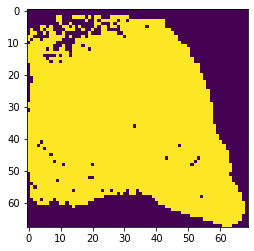

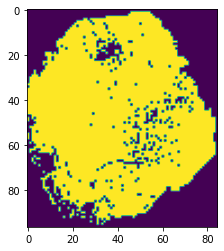

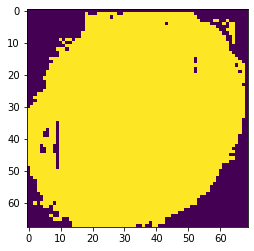

In [9]:
scale = 3

mut_mask = mask_infisble(mut_sample_list, scale, probability=0.6, plot=True)
data4model = generate_data4model(samples_list=mut_sample_list, genes=tree.columns, M=M, n_aug=1)

n_samples = data4model['n_samples']
n_genes = data4model['n_genes']
iss_data = data4model['iss_data']
tiles_axes = data4model['tiles_axes']
cells_counts = data4model['cells_counts']
sample_dims = data4model['sample_dims']
n_factors = data4model['n_factors']
n_aug = data4model['n_aug']

mask = mut_mask

### Calculating CD45+ (immune) cell fractions

IHC data reveals part of cell type heterogeneity. In our study we mainly worked with CD45 IHC staining which indicates location of lymphocytes. As we know that none of the lymphocytes should contribute to cancer clone weights, we could further regularise clone weights. 

We use a Beta pseudo-likelihood of $\mathbf{CellFrac}$ distribution with $\alpha$ and $\beta$ parameters equal to cell counts of clear and IHC stained nuclei on the slide.

$$
\mathbf{CellFrac}_{x,y} \sim \mathrm{Beta}(\alpha=\text{IHC}^\text{ -}_{x,y} + 1, \alpha=\text{IHC}^\text{ +}_{x,y} + 1)
$$

In [10]:
cells_counts_CD45 = to_grid(x_raw=pd14780e_CD45.x,
                    y_raw=pd14780e_CD45.y, 
                    grid_params=mut_sample_list[2].grid_params,
                    img_size=mut_sample_list[2].spatial_dims).flatten()

with open('../submission/external_data/PD14780/IHC/masks/Imm_PD14780e_cells_warped.npy', 'rb') as file:
    pd14780e_cellpos_warped_from_imm = np.load(file)
    
cells_counts_complemet = to_grid(x_raw=pd14780e_cellpos_warped_from_imm[:,0],
                    y_raw=pd14780e_cellpos_warped_from_imm[:,1], 
                    grid_params=mut_sample_list[2].grid_params,
                    img_size=mut_sample_list[2].spatial_dims).flatten()

mut_mask[2] = mut_mask[2] * (np.abs(mut_sample_list[2].cell_grid - cells_counts_complemet.reshape(mut_sample_list[2].cell_grid.shape)) / mut_sample_list[2].cell_grid < 0.5).flatten()

/tmp/ipykernel_3662101/2337906712.py:14: RuntimeWarning: divide by zero encountered in true_divide
  mut_mask[2] = mut_mask[2] * (np.abs(mut_sample_list[2].cell_grid - cells_counts_complemet.reshape(mut_sample_list[2].cell_grid.shape)) / mut_sample_list[2].cell_grid < 0.5).flatten()
/tmp/ipykernel_3662101/2337906712.py:14: RuntimeWarning: invalid value encountered in true_divide
  mut_mask[2] = mut_mask[2] * (np.abs(mut_sample_list[2].cell_grid - cells_counts_complemet.reshape(mut_sample_list[2].cell_grid.shape)) / mut_sample_list[2].cell_grid < 0.5).flatten()


## Define and run the model

The essential idea is that the expected number of BaSISS signals is decomposed into maps of $|s|$ distinct clones $s$ $\mathbf{M} \in \mathbb{R}^{|s|\times |x| \times |y|}$ each with a distinct genotype $\mathbf{G} \in \mathbb{N}^{|a|\times |s|}$,

$$\mathbb{E}[\mathbf{D}] \approx \mathbf{G} \times \mathbf{M} = \sum_{s \in \text{subclones}} \mathbf{G}_{\cdot, s} \mathbf{M}_{s, \cdot, \cdot}$$

Accounting for sources of noise, this equation for the expected number of BaSISS signals becomes:


$$\boldsymbol{\mu}_{a, x,y} = \underbrace{\boldsymbol{\nu}_{x,y}}_{\text{cell density}} \cdot \overbrace{\boldsymbol{\iota}_a}^{ {\text{detection rate}}} \cdot \underbrace{\sum_{a'} \boldsymbol{\tau}_{a,a'}}_{\text{probe confusion}} \sum_s  \overbrace{\boldsymbol{\gamma}_{s,a}}^{ {\text{clone-specific expression}}} \underbrace{\mathbf{G}_{a,s} \mathbf{M}_{s,x,y}}_{\text{clone contribution}} + \overbrace{\boldsymbol{\beta}_a}^{ {\text{background}}}$$

For more detials see Suppl. Methods 

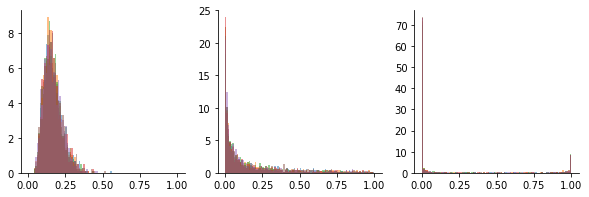

In [11]:
fig, axs = plt.subplots(1,3,figsize=(10,3))
ts = [0.4,2,10]
for i, ax in enumerate(axs):
    gaussian_prior_check(n_factors=n_factors, n_aug=n_aug, t=ts[i], ax=ax)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

In [12]:
with pm.Model() as model_hierarchical_errosion:
    xi = [pm.Gamma('xi_{}'.format(s), mu=0.5, sigma=1, shape=n_genes) for s in range(n_samples)]
    r_mu = pm.Gamma('r', mu=0.5, sigma=1, shape=n_genes)
    r_de = [pm.Lognormal('r_de_{}'.format(s), mu=0, sigma=0.05, shape=n_genes) for s in range(n_samples)]
    r = [r_mu * r_de_i for r_de_i in r_de]

    cov_func1_f = [[pm.gp.cov.ExpQuad(1, ls=1*np.sqrt(scale)) for i in range(n_factors-1 + n_aug)] for s in range(n_samples)]
    cov_func2_f = [[pm.gp.cov.ExpQuad(1, ls=1*np.sqrt(scale)) for i in range(n_factors-1 + n_aug)] for s in range(n_samples)]

    gp_f = [[pm.gp.LatentKron(cov_funcs=[cov_func1_f[s][i], cov_func2_f[s][i]]) for i in range(n_factors - 1 + n_aug)] for s in range(n_samples)] 
    f_f = [[gp_f[s][i].prior(name, Xs=tiles_axes[s]) for i, name in enumerate(['f_f_{}_{}'.format(i, s) for i in range(n_factors - 1 + n_aug)])] for s in range(n_samples)]
    f_f = [f_f[s] + [np.ones(len(cells_counts[s]))*(-1.7)] for s in range(n_samples)]
    F_matrix = [at.stack(f_f[s], axis=1) for s in range(n_samples)]
    
    F = [pm.Deterministic('F_{}'.format(s), at.exp(F_matrix[s] * 2) / at.exp(F_matrix[s] * 2).sum(axis=1)[:,None]) for s in range(n_samples)]

    lm_n = [pm.Gamma('lm_n_{}'.format(s), mu=50, sigma=100, shape=len(cells_counts[s])) for s in range(n_samples)]
    pois_n = [pm.Poisson('n_{}'.format(s), lm_n[s], observed=cells_counts[s]) for s in range(n_samples)]  
    E0 = 4 ## ie 1 for most loci; 4 for amps
    E = [E0 * pm.Beta(f'E_{s}',0.01,1, shape=(n_aug, n_genes)) for s in range(n_samples)] #(M - M[-1,:]).max(0) 
    
    M_de = pm.Lognormal("M_de", mu=0.0, sigma=0.05, shape=M.shape) #pm.Lognormal('M_de', mu=0.0, sigma=0.05, shape=M.shape)    
    M_de = at.pow(M_de, at.concatenate([at.ones((n_factors-n_wt,1)), 2 * at.ones((n_wt,1))],axis=0))
    M_aug = M * M_de
    M_aug_de = [pm.Bound(f"M_de_{s}", pm.Lognormal.dist(mu=0.0, sigma=0.05), lower=1e-1, upper=1e1, shape=(n_factors, n_genes)) for s in range(n_samples)]#[pm.Lognormal(f'M_aug_{s}', mu=0.0, sigma=0.05, shape=(n_factors, n_genes)) for s in range(n_samples)]

    
    theta_pure = [pm.Deterministic('theta_{}'.format(s), at.dot(F[s], at.concatenate([M,E[s]]))) for s in range(n_samples)]
    
    #M_aug = at.concatenate([M_aug[:n_factors-1,:], M_aug[None,-1,:]], axis=0)
    theta = [pm.Deterministic('theta_mod_{}'.format(s), at.dot(F[s], at.concatenate([M_aug * M_aug_de[s] , E[s]], axis=0))) for s in range(n_samples)] #* M_aug_de[s]

   
    z = 1 - pm.Beta('z', 1, 25, shape=n_genes)/4 ## ie ~1% probe confusion
    
    confusion_matrix = at.eye(n_genes)

    for i in range(n_genes):
        for j in range(n_genes):
            if tree.columns[i].endswith('mut') and tree.columns[j].endswith('mut') and tree.columns[i][:-3] == tree.columns[j][:-3]:
                confusion_matrix = at.set_subtensor(confusion_matrix[i, j], z[i])
    
            if tree.columns[i].endswith('wt') and tree.columns[j].endswith('wt') and tree.columns[i][:-2] == tree.columns[j][:-2]:
                confusion_matrix = at.set_subtensor(confusion_matrix[i, j], z[i])#
    
            if tree.columns[i][:-3] == tree.columns[j][:-2]:
                confusion_matrix = at.set_subtensor(confusion_matrix[i, j], 1-z[i])#
    
            if tree.columns[i][:-2] == tree.columns[j][:-3]:
                confusion_matrix = at.set_subtensor(confusion_matrix[i, j], 1-z[i])

    
    lm = [theta[s]  * lm_n[s][:, None] * r[s][None,:] for s in range(n_samples)]
    
    

    T = [at.dot(F[s].sum(axis=0), at.concatenate([M, E[s]], axis=0)) for s in range(n_samples)] ## Just sum actual genotypes
    T_freq = [T[s][[np.where(tree.columns == gene + 'mut')[0][0] for gene in wgs_names]] \
              / (T[s][[np.where(tree.columns == gene + 'wt')[0][0] for gene in wgs_names]] \
                 + T[s][[np.where(tree.columns == gene + 'mut')[0][0] for gene in wgs_names]]) for s in range(n_samples)]

    beta_prior = [pm.Potential('beta_prior_{}'.format(s), beta_sum_logp(T_freq[s][:], (mask[s].sum()), (wgs_mut[s]/u + 1), (wgs_wt[s]/u + 1)) ) for s in range(n_samples)]
    
    s=2
    W_freq = F[s][:,n_factors-1] / F[s][:,:n_factors].sum(axis=1)
    
    pm.Potential('cd45_prior_{}'.format(s), pm.logp(pm.Beta.dist(alpha=(cells_counts_CD45 + 1), beta=((cells_counts_complemet-cells_counts_CD45) + 1)), W_freq))    

    lm_er = [pm.Deterministic('lm_er_{}'.format(s), at.dot(lm[s], confusion_matrix) + xi[s][None,:]) for s in range(n_samples)]
    
    o = pm.Gamma('o', mu=100, sigma=10, shape=n_genes)

    signal = [pm.NegativeBinomial('exp_{}'.format(s), mu = lm_er[s][mask[s],:], alpha=o, observed=iss_data[s][mask[s],:]) for s in range(n_samples)]

In [ ]:
#run one iteration to obtain parameter mapping
with model_hierarchical_errosion:
    advi = pm.ADVI(random_seed=74)
    approx_hierarchical_errosion = advi.fit(n=1, obj_optimizer=pm.adam(learning_rate=0.01))  

#track the means of nodes
def fk(k, n_nodes, memorised = {'m':None, 'steps':0}):
    def f():
        if memorised['steps'] % n_nodes == 0:
            memorised['m'] = advi.approx.params[0].eval()
        memorised['steps'] += 1
        return np.mean(memorised['m'][advi.approx.ordering[k][1]])
    return f

kwargs_params = {}
memorised = {'m':None, 'steps':0}
for k in approx_hierarchical_errosion.ordering.keys():
    kwargs_params[k] = fk(k, n_nodes=37,memorised = memorised)
tracker = pm.callbacks.Tracker(**kwargs_params)
len(approx_hierarchical_errosion.ordering.keys())


In [ ]:
#main inference run
with model_hierarchical_errosion :
    advi = pm.ADVI(random_seed=74)
    approx_hierarchical_errosion = advi.fit(n=10000, obj_optimizer=pm.adam(learning_rate=0.01), callbacks=[tracker])
plt.plot(approx_hierarchical_errosion.hist[1000:])

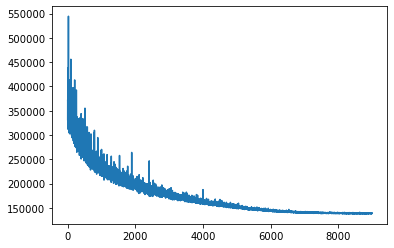

In [13]:
#save/load model
#with open('../submission/generated_data/models/PD14780_bassis_model.pkl', 'wb') as file:
#    cpkl.dump(approx_hierarchical_errosion, file)
with open('../submission/generated_data/models/PD14780_bassis_model.pkl', 'rb') as file:
    approx_hierarchical_errosion = cpkl.load(file)
plt.plot(approx_hierarchical_errosion.hist[1000:])

In [ ]:
#with open('../scripts/models/PD14780_bassis_model_74.pkl', 'rb') as file:
#    approx_hierarchical_errosion = cpkl.load(file)

In [ ]:
#plt.plot(approx_hierarchical_errosion.hist[1000:])

In [ ]:
#plt.figure(figsize=(16,12))
#for i, k in enumerate(tracker.hist.keys()):
#    plt.subplot(10,10, i+1)
#    plt.plot(tracker[k], color='darkorange')
#    plt.title(k)
#    plt.gca().spines['top'].set_visible(False)
#    plt.gca().spines['right'].set_visible(False)
#plt.tight_layout()

In [14]:
#stochastic samplinh
samples_hierarchical_errosion = approx_hierarchical_errosion.sample(100)

In [ ]:
#save essential parameters - fields and cell density, used if need a high precision and approximation sampling reproducibility
params2save = store_essential_params(approx_hierarchical_errosion, n_samples=n_samples, n_factors=n_factors, n_aug=n_aug, tiles_axes=tiles_axes, scale=3)
with open('../submission/generated_data/models/PD14780_bassis_model_params.pkl', 'wb') as file:
    cpkl.dump(params2save, file)

In [15]:
with open('../submission/generated_data/models/PD14780_bassis_model_params.pkl', 'rb') as file:
    params2save = cpkl.load(file)

In [16]:
model_params_samples = sample_essential(params2save, n_factors=n_factors, samples=[0,1,2], n_draws=500, seed=123)

100%|██████████| 3/3 [00:04<00:00,  1.55s/it]


### Display fields 

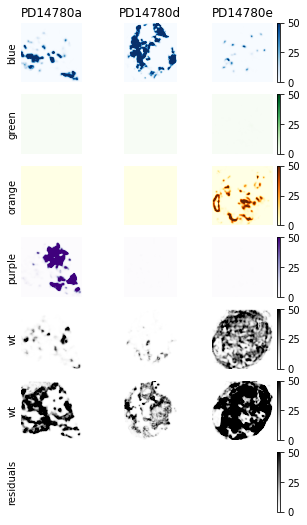

In [17]:
sample_names = ['PD14780' + x for x in 'ade']
display_raw_fields(model_params_samples,
                   field_names=['blue', 'green', 'orange', 'purple'] + 2 * ['wt'] + 1 *['residuals'],
                   sample_names=sample_names,
                   figsize=(5,9))


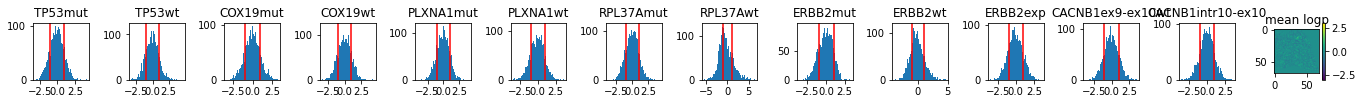

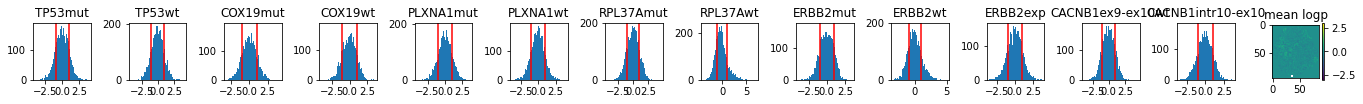

/nfs/research/gerstung/alomakin/projects/bassis/repo/BaSISS/notebooks/../basiss/models/diagnostic_plots.py:54: RuntimeWarning: invalid value encountered in multiply
  qnorm = stats.norm.ppf(ppois) * mask[s].reshape(-1,1)


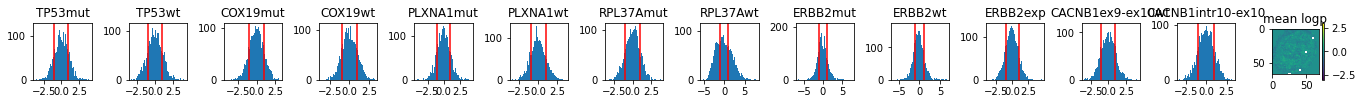

In [18]:
diagnostic_residual(samples_hierarchical_errosion, iss_data=iss_data,
                    mask=mask, tree=tree, sample_dims=sample_dims,
                    samples=[0,1,2], plot_type='hist', subplots=(5,15), figsize=(20,6))

### Plot maps 

Maps of the most prevalent clone projected on the DAPI image (reported if
cancer cell fraction > 25% (> 15% for lymph node) and inferred local cell density > 300 cells/mm$^2$), and frequency plots of local, mean
cancer (coloured areas) and non-cancer (white) composition, corresponding to horizontal dashed
lines.

In [19]:
from basiss.plots import plot_density_stacked, format_number, plot_field
from matplotlib.ticker import FormatStrFormatter, FuncFormatter


In [20]:
stackplot_params = {0: [21, 39, 59], 1:[14, 38, 55], 2:[12, 25, 40]}

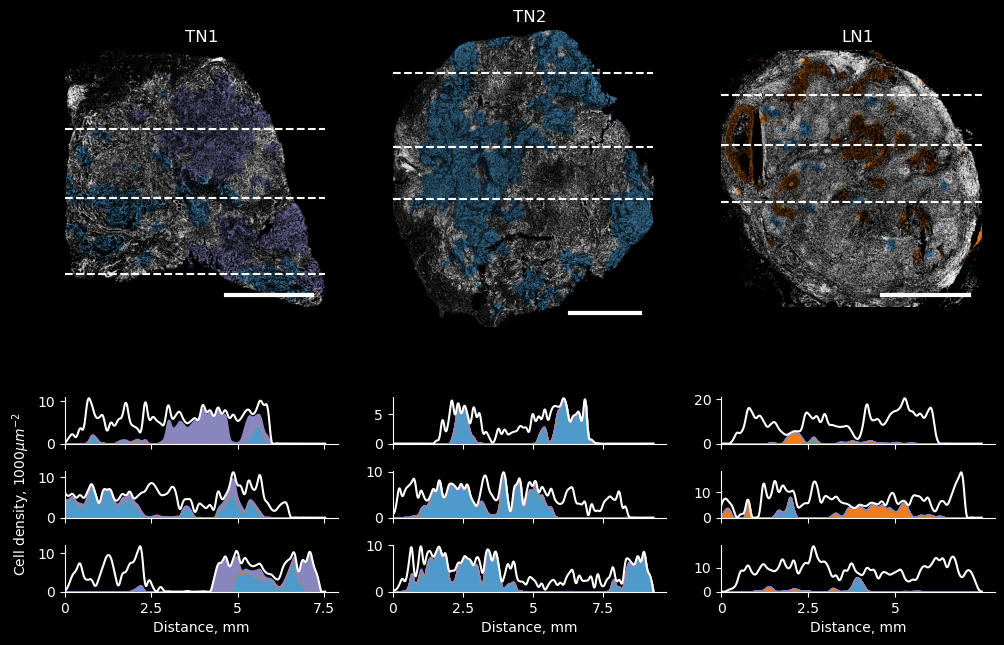

In [21]:
def format_number(x, dec=1):
    x = float(x)
    if x % 1 == 0:
        return int(x)
    else:
        return round(x, dec)

pixel2um = 0.325
grid_mm2 = (Sample.get_img_size(mut_sample_list[0].image)[0] \
            * pixel2um / model_params_samples['F_0'].shape[1]) ** 2/ 1e6
flipped = [False, False, True]
plot_names = ['TN1', 'TN2', 'LN1']
ths = [[0.75, 0.75, 0.75, 0.75],
       [0.75, 0.75, 0.75, 0.75],
       [0.95, 0.95, 0.95, 0.95]]
fig, axs = plt.subplots(4, n_samples, figsize=(12,8), sharex='col', gridspec_kw={'height_ratios': [8,1,1,1]}, dpi=100)
fig.set_facecolor('black')
for i in range(n_samples):
    plot_field(mut_sample_list[i],
           model_params_samples[f'F_{i}'],
           model_params_samples[f'lm_n_{i}'],
           ax=axs[0,i],
           flip=flipped[i],
           th=ths[i])
    axs[0,i].set_title(plot_names[i])
    axs[0,i].title.set_color('white')
    for j in range(3):
        image_dims = mut_sample_list[i]._scaffold_image.shape
        axs[0,i].hlines(stackplot_params[i][j] / sample_dims[i][1] * image_dims[0],
                        xmin=0,
                        xmax=image_dims[1],
                        color='white', linestyle='--')
        plot_density_stacked(model_params_samples[f'F_{i}'],
                             model_params_samples[f'lm_n_{i}'],
                             stackplot_params[i][j],
                             names = ['blue','green', 'orange', 'purple', 'wt'],
                             wt_colour='white',
                             grid_mm2 = grid_mm2,
                             flipped=flipped[i],
                             ax=axs[j+1,i],
                             rescale_x=image_dims[1])
        axs[j+1,i].set_xticks(np.arange(0, image_dims[1], 2.5 / (15 * pixel2um / 1e3)))
        xticklabels = np.arange(0, image_dims[1] * 15 * pixel2um / 1e3, 2.5)
        xticklabels = [format_number(x) for x in xticklabels]
        axs[j+1,i].set_xticklabels(xticklabels)
        axs[j+1,i].set_facecolor('black')
        axs[j+1,i].xaxis.label.set_color('white')
        axs[j+1,i].yaxis.label.set_color('white')
        axs[j+1,i].tick_params(colors='white', which='both')
        axs[j+1,i].spines['left'].set_color('white')
        axs[j+1,i].spines['bottom'].set_color('white')
    axs[-1,i].set_xlabel('Distance, mm')
    axs[2,0].set_ylabel('Cell density, $1000 \mu m^{-2}$')
        
        
